# Setup

The following cells include the essential importation of libraries, as well as helper functions that are used throughout the notebook.

In [44]:
import os, gc, random

import pandas as pd
import math
import numpy as np

import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    classification_report,
)
from sklearn.preprocessing import MinMaxScaler as MMS

import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Input, Model

from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Input,
    Add,
    Activation,
    ZeroPadding2D,
    GlobalAveragePooling2D,
)

from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    AveragePooling2D,
    MaxPooling2D,
    GlobalMaxPooling2D,
    LeakyReLU,
)

from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint,
)

from tensorflow.keras.initializers import (
    glorot_uniform,
    he_uniform,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import (
    preprocess_input,
    decode_predictions,
    preprocess_input,
)

from tensorflow.keras.models import Model, load_model
from tensorflow.keras import utils
from tensorflow.keras.utils import get_file, plot_model, to_categorical, model_to_dot
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, VGG16
import tensorflow.keras.backend as K

import cv2
from PIL import Image
import glob
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.patches import Circle
import scipy as sp

import tensorflow as tf
import numpy as np
from tf_explain.core.grad_cam import GradCAM

import seaborn as sns

from tensorflow.keras.applications import ResNet50V2

This is a garbage collection function to clear as much memory as possible, and prevent the system from crashing.

In [45]:
def reset_keras():
    tensorflow.keras.backend.clear_session
    gc.collect()

The function is called first to set the stage for the memory to be occupied as much as possible by the following tasks.

In [46]:
reset_keras()

# Data Manipulation

This section focuses on loading, and preparing data for training, and testing from TFRecord files. A random seed is firstly set so that results are reproducibile.

In [47]:
SEED = 1234
random.seed(SEED)
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(SEED)

Two empty lists are initialised for images, and labels.

In [48]:
images, labels = [], []

A dictionary is defined that specifies the structure of TFRecord data.

In [49]:
features = {
    "label": tf.io.FixedLenFeature([], tf.int64),
    "label_normal": tf.io.FixedLenFeature([], tf.int64),
    "image": tf.io.FixedLenFeature([], tf.string),
}

A function is defined to process the TFRecord files, and store the results into the previously defined ```images```, and ```labels``` lists.

In [50]:
def read_file(files):
    mydata = (
        tf.data.TFRecordDataset(files, num_parallel_reads=4)
        .shuffle(buffer_size=10000)
        .cache()
    )
    mydata = mydata.map(
        lambda x: tf.io.parse_example(x, features), num_parallel_calls=4
    )
    for image_features in mydata:
        image = tf.io.decode_raw(image_features["image"], tf.uint8)
        image = tf.reshape(image, [299, 299])
        image = np.asarray(image)
        images.append(image)
        labels.append(image_features["label"].numpy())

The garbage collection function is invoked before the files are parsed, to avoid any memory issues.

In [51]:
reset_keras()

The target TFRecord files are defined in a list, prior to being processed.

In [52]:
files = [
    "./data/training10_0/training10_0.tfrecords",
    "./data/training10_1/training10_1.tfrecords",
    "./data/training10_2/training10_2.tfrecords",
    "./data/training10_3/training10_3.tfrecords",
    "./data/training10_4/training10_4.tfrecords",
]

The parsing function is called on the previously defined list.

In [53]:
for file in files:
    read_file(file)

2025-08-07 16:43:01.472310: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Preparing Data for Training

This section will encompass cells that process the already loaded training data to make it more understandable to the CNN later in the notebook. Each image is first saved as a ```.jpg``` file in the ```train``` directory with enumerated filenames. The list of labels is saved as a CSV file within the same directory.

In [54]:
x = 0
for image in images:
    tmp = "./train/"
    tmp += str(x)
    tmp += ".jpg"
    plt.imsave(tmp, image)
    x += 1
np.savetxt("./train/labels.csv", labels, delimiter=",")

The labels are loaded, and converted to boolean format, ideal for the binary classification task the CNN is to perform.

In [55]:
y_train = np.loadtxt("./train/labels.csv", delimiter=",").astype("int")
y_train = np.where(y_train == 0, 0, y_train)
y_train = np.where(y_train != 0, 1, y_train)
print(np.bincount(y_train) / len(y_train))
y_train = y_train.astype("str")

[0.86957144 0.13042856]


The list of ```.jpg``` files from the ```train``` directory is retrieving using ```glob```, with the numeric part of the filename extracted, and storing in the ```mysplit``` list for further sorting.

In [56]:
myf = glob.glob("./train/*.jpg")
mysplit = []

for file in myf:
    filename = file.split("/")[-1]
    number = int(filename.split(".")[0])
    mysplit.append(number)

A Pandas DataFrame is defined for training, with columns to store the image paths, and binary label, all sorted by their numeric value.

In [57]:
d = {"file": myf, "number": mysplit}
traindf = pd.DataFrame(d)
traindf = traindf.sort_values(by=["number"])
traindf["label"] = y_train

## Preparing Data for Testing

This section applies methods similar to those seen within the previous section, but more suited towards preparing testing data. The following cell begins by loading test images, and labels from NumPy files, and concatenates them to form ```x_test``` for images, and ```y_test``` for labels. The ```y_test``` array is then converted to boolean format as was done for training labels.

In [58]:
x_test = np.concatenate(
    (
        np.load("./data/cv10_data/cv10_data.npy"),
        np.load("./data/test10_data/test10_data.npy"),
    )
)
y_test = np.concatenate(
    (np.load("./data/cv10_labels.npy"), np.load("./data/test10_labels.npy"))
)
y_test = np.where(y_test == 0, 0, y_test)
y_test = np.where(y_test != 0, 1, y_test)

The testing data is then saved as ```.jpg``` files within the ```test``` directory with enumerated filenames.

In [59]:
x = 0
for i in range(x_test.shape[0]):
    tmp = "./test/"
    tmp += str(x)
    tmp += ".jpg"
    plt.imsave(tmp, x_test[i, :, :, 0])
    x += 1
np.savetxt("./test/y_test.csv", y_test, delimiter=",")

The test labels are then loaded from the CSV file, and casted as strings.

In [60]:
y_test = np.loadtxt("./test/y_test.csv", delimiter=",").astype("int")
print(np.bincount(y_test) / len(y_test))
y_test = y_test.astype("str")

[0.86956522 0.13043478]


Similar to the previous section, the filenames are retrieved as a list of ```.jpg``` files using ```glob```, with the numeric part of the filename extracted via ```glob```.

In [61]:
myf2 = glob.glob("./test/*.jpg")
mysplit = []

for file in myf2:
    filename = file.split("/")[-1]
    number = int(filename.split(".")[0])
    mysplit.append(number)

A Pandas DataFrame is created with this information.

In [62]:
d = {"file": myf2, "number": mysplit}
testdf = pd.DataFrame(d)
testdf = testdf.sort_values(by=["number"])
testdf["label"] = y_test

## Visualisation

The dataset is visualised within this section, with the garbage collection function being called first to alleviate the system's memory as much as possible.

In [63]:
reset_keras()

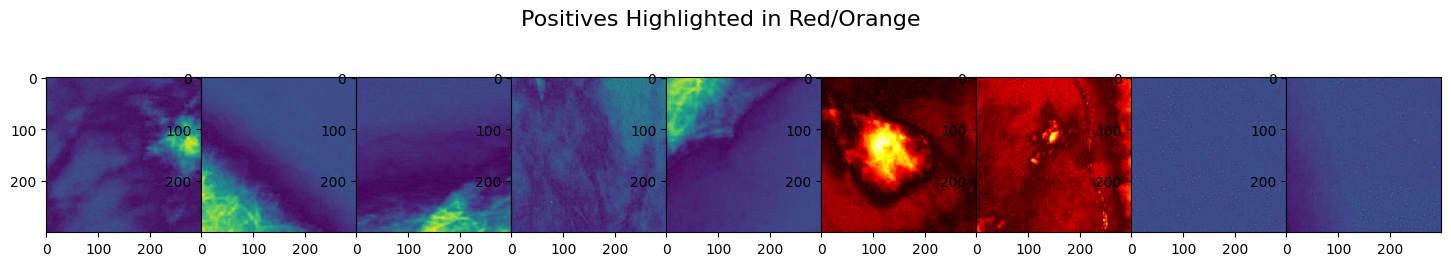

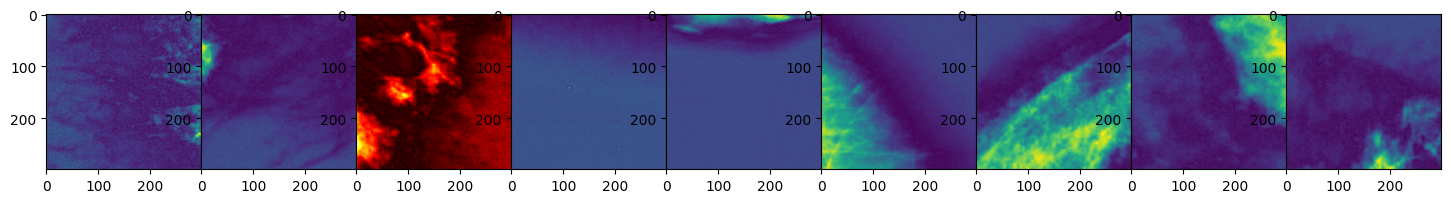

In [64]:
fig, ax = plt.subplots(1, 9, figsize=[18, 3])
fig2, ax2 = plt.subplots(1, 9, figsize=[18, 3])
fig.suptitle("Positives Highlighted in Red/Orange", fontsize=16)

for i in range(9):
    tmp = plt.imread(traindf.iloc[i, 0])
    tmp = tmp[:, :, 0]
    tmp2 = y_train[i].astype("int")
    ax[i].imshow(tmp) if tmp2 == 0 else ax[i].imshow(tmp, cmap="hot")
    fig.subplots_adjust(wspace=0, hspace=0)

for i in range(9):
    tmp = plt.imread(testdf.iloc[i, 0])
    tmp = tmp[:, :, 0]
    tmp2 = y_test[i].astype("int")
    ax2[i].imshow(tmp) if tmp2 == 0 else ax2[i].imshow(tmp, "hot")
    fig2.subplots_adjust(wspace=0, hspace=0)

## Data Generators

The data processed in the previous steps is finally encapsulated into generators to feed it into the model during training, and testing. An ```ImageDataGenerator``` object is first defined to preprocess images by rescaling their pixel values. Each pixel is normalised into the range [0, 255] by being divided by 255. This is known to improve the model's training efficiency, and performance.

In [65]:
random.seed(1234)

In [66]:
datagen = ImageDataGenerator(rescale=1.0 / 255)

The training generator yields batches of preprocessed training images, and their corresponding labels from the ```traindf``` DataFrame. This feeds the model during training.

In [67]:
train_generator = datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=None,
    x_col="file",
    y_col="label",
    class_mode="binary",
    color_mode="rgb",
    target_size=(299, 299),
    shuffle=True,
    batch_size=8,
    subset="training",
)

Found 55885 validated image filenames belonging to 2 classes.


A similar generator is made for the testing set.

In [68]:
test_generator = datagen.flow_from_dataframe(
    testdf,
    x_col="file",
    y_col="label",
    class_mode="binary",
    color_mode="rgb",
    target_size=(299, 299),
    batch_size=8,
    shuffle=False,
)

Found 15364 validated image filenames belonging to 2 classes.


# VGG16 Model

The model used for binary classification of breast tissue is a convolutional neural network, based upon a frozen ```VGG16``` layer, that uses pre-trained ```ImageNet``` weights. This is then followed by ```Dense```, and ```GlobalAveragePooling2D``` layers, and fine-tuned accordingly.

In [69]:
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

In [70]:
classifier_head = vgg16_base.output
classifier_head = GlobalAveragePooling2D()(classifier_head)
classifier_head = Dense(1, activation="sigmoid", name="classifier")(classifier_head)
vgg16_model = Model(vgg16_base.input, classifier_head)
vgg16_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 299, 299, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 299, 299, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 149, 149, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 149, 149, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 149, 149, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 74, 74, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 74, 74, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 74, 74, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 14,715,201 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

The model will now be trained, based on the previous definition. Garbage collection is called prior to training, to avoid memory issues.

In [71]:
reset_keras()

Important callbacks are first defined to stop training if parameters like validation loss do not improve, and for the model with best validation accuracy to be saved.

In [72]:
early = EarlyStopping(
    monitor="val_loss", mode="min", patience=3, restore_best_weights=True, verbose=2
)
checkpoint = ModelCheckpoint(
    "../models/best_model_vgg16.keras",
    monitor="accuracy",
    verbose=2,
    save_best_only=True,
    mode="auto",
)

The model is compiled with an ```adagrad``` optimisation function, and binary cross-entropy loss function.

In [73]:
vgg16_model.compile(optimizer="adagrad", loss="binary_crossentropy", metrics=["accuracy"])

The model is finally trained, with data being fed from the previously defined generators.

In [75]:
vgg16_model_history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=3,
    callbacks=[checkpoint, early],
    validation_data=test_generator,
)

Epoch 1/3
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8796 - loss: 0.3025
Epoch 1: accuracy improved from -inf to 0.89355, saving model to ../models/best_model_vgg16.keras
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 1277s 183ms/step - accuracy: 0.8796 - loss: 0.3025 - val_accuracy: 0.9244 - val_loss: 0.2054
Epoch 2/3
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9278 - loss: 0.1834
Epoch 2: accuracy improved from 0.89355 to 0.93347, saving model to ../models/best_model_vgg16.keras
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 1272s 182ms/step - accuracy: 0.9278 - loss: 0.1834 - val_accuracy: 0.9468 - val_loss: 0.1424
Epoch 3/3
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9475 - loss: 0.1405
Epoch 3: accuracy improved from 0.93347 to 0.95025, saving model to ../models/best_model_vgg16.keras
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 1263s 181ms/step - accuracy: 0.9475 - loss: 0.1405 - val_accuracy: 0.9519 - val_loss: 0.1284
Restoring model weights from the end of the best epoch: 3.


In [76]:
vgg16_model = load_model('../models/best_model_vgg16.keras')

# ResNet50 Model

The process for defining, compiling, and training the ResNet50 model is very similar to that of the VGG16 model.

In [77]:
resnet50_base = ResNet50V2(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

In [78]:
classifier_head = resnet50_base.output
classifier_head = GlobalAveragePooling2D()(classifier_head)
classifier_head = Dense(1, activation="sigmoid", name="classifier")(classifier_head)
resnet50_model = Model(resnet50_base.input, classifier_head)
resnet50_model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 305, 305,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 150,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 152, 152,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 75, 75,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 75, 75,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 75, 75,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 75,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 75,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 75,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 77, 77,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 75,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 75, 75,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 75, 75,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 75, 75,    │          0 │ conv2_block1_0_c

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 23,521,409 (89.73 MB)

 Non-trainable params: 45,440 (177.50 KB)

## Training the Model

In [79]:
reset_keras()

In [80]:
early = EarlyStopping(
    monitor="val_loss", mode="min", patience=3, restore_best_weights=True, verbose=2
)
checkpoint = ModelCheckpoint(
    "../models/best_model_resnet.keras",
    monitor="accuracy",
    verbose=2,
    save_best_only=True,
    mode="auto",
)

In [81]:
resnet50_model.compile(optimizer="adagrad", loss="binary_crossentropy", metrics=["accuracy"])

In [82]:
resnet50_model_history = resnet50_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=3,
    callbacks=[checkpoint, early],
    validation_data=test_generator,
)

Epoch 1/3
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9175 - loss: 0.2164
Epoch 1: accuracy improved from -inf to 0.93811, saving model to ../models/best_model_resnet.keras
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 582s 80ms/step - accuracy: 0.9175 - loss: 0.2164 - val_accuracy: 0.9599 - val_loss: 0.1091
Epoch 2/3
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9685 - loss: 0.0863
Epoch 2: accuracy improved from 0.93811 to 0.96894, saving model to ../models/best_model_resnet.keras
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 541s 77ms/step - accuracy: 0.9685 - loss: 0.0863 - val_accuracy: 0.9662 - val_loss: 0.0930
Epoch 3/3
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9791 - loss: 0.0585
Epoch 3: accuracy improved from 0.96894 to 0.97987, saving model to ../models/best_model_resnet.keras
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 541s 77ms/step - accuracy: 0.9791 - loss: 0.0585 - val_accuracy: 0.9700 - val_loss: 0.0877
Restoring model weights from the end of the best epoch: 3.


In [84]:
resnet50_model = load_model('../models/best_model_resnet.keras')

## Vision Transformer

In [132]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

custom_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

custom_cnn.summary()

/home/isaac/miniconda3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 297, 297, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 297, 297, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 146, 146, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 71, 71, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    20,070,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,164,801 (76.92 MB)

 Trainable params: 20,164,353 (76.92 MB)

 Non-trainable params: 448 (1.75 KB)

In [133]:
custom_cnn.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [134]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=2)
checkpoint = ModelCheckpoint("../models/best_model_custom.keras", monitor="accuracy", save_best_only=True, verbose=2)

In [135]:
custom_cnn_history = custom_cnn.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=3,
    callbacks=[checkpoint, early],
    validation_data=test_generator
)

Epoch 1/3
6985/6986 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8520 - loss: 5.0306
Epoch 1: accuracy improved from -inf to 0.86488, saving model to ../models/best_model_custom.keras
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 204s 28ms/step - accuracy: 0.8520 - loss: 5.0297 - val_accuracy: 0.8696 - val_loss: 0.3651
Epoch 2/3
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8724 - loss: 0.3886
Epoch 2: accuracy improved from 0.86488 to 0.87345, saving model to ../models/best_model_custom.keras
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 190s 27ms/step - accuracy: 0.8724 - loss: 0.3886 - val_accuracy: 0.8696 - val_loss: 0.3885
Epoch 3/3
6985/6986 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8711 - loss: 0.3844
Epoch 3: accuracy did not improve from 0.87345
6986/6986 ━━━━━━━━━━━━━━━━━━━━ 188s 27ms/step - accuracy: 0.8711 - loss: 0.3844 - val_accuracy: 0.8696 - val_loss: 0.3873
Restoring model weights from the end of the best epoch: 1.


In [136]:
from tensorflow.keras.models import load_model

custom_cnn = load_model('../models/best_model_custom.keras')

## Evaluating the Models

In [85]:
reset_keras()

This section evaluates the previously trained models using standard metrics like accuracy, and loss on the training, and validation sets. In the following cell, these metrics are extracted into variables for later use from the performance of the model across different epochs during training.

In [142]:
custom_cnn_accuracy = []
vgg16_accuracy = []
resnet50_accuracy = []
custom_cnn_loss = []
vgg16_loss = []
resnet50_loss = []
custom_cnn_val_accuracy = []
vgg16_val_accuracy = []
resnet50_val_accuracy = []
custom_cnn_val_loss = []
vgg16_val_loss = []
resnet50_val_loss = []

In [143]:
custom_cnn_accuracy.append(custom_cnn_history.history["val_accuracy"])
custom_cnn_val_loss.append(custom_cnn_history.history["val_loss"])
custom_cnn_val_accuracy.append(custom_cnn_history.history["accuracy"])
custom_cnn_loss.append(custom_cnn_history.history["loss"])

vgg16_accuracy.append(vgg16_model_history.history["val_accuracy"])
vgg16_val_loss.append(vgg16_model_history.history["val_loss"])
vgg16_val_accuracy.append(vgg16_model_history.history["accuracy"])
vgg16_loss.append(vgg16_model_history.history["loss"])

resnet50_accuracy.append(resnet50_model_history.history["val_accuracy"])
resnet50_val_loss.append(resnet50_model_history.history["val_loss"])
resnet50_val_accuracy.append(resnet50_model_history.history["accuracy"])
resnet50_loss.append(resnet50_model_history.history["loss"])

This is then plotted, to visualise how the model's accuracy, and loss scores improved.

In [148]:
def compare_model_performance_plot(vgg_acc, vgg_val_acc, vgg_loss, vgg_val_loss,
                                   resnet_acc, resnet_val_acc, resnet_loss, resnet_val_loss,
                                   custom_cnn_acc, custom_cnn_val_acc, custom_cnn_loss, custom_cnn_val_loss,):
    
    epochs = range(1, len(vgg_acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle("Model Performance Comparison", fontsize=16)

    ax1.plot(epochs, custom_cnn_acc, label='Custom CNN - Train', linestyle='--')
    ax1.plot(epochs, custom_cnn_val_acc, label='Custom CNN - Val')
    ax1.plot(epochs, vgg_acc, label='VGG16 - Train', linestyle='--')
    ax1.plot(epochs, vgg_val_acc, label='VGG16 - Val')
    ax1.plot(epochs, resnet_acc, label='ResNet50 - Train', linestyle='--')
    ax1.plot(epochs, resnet_val_acc, label='ResNet50 - Val')
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, custom_cnn_loss, label='Custom CNN - Train', linestyle='--')
    ax2.plot(epochs, custom_cnn_val_loss, label='Custom CNN - Val')
    ax2.plot(epochs, vgg_loss, label='VGG16 - Train', linestyle='--')
    ax2.plot(epochs, vgg_val_loss, label='VGG16 - Val')
    ax2.plot(epochs, resnet_loss, label='ResNet50 - Train', linestyle='--')
    ax2.plot(epochs, resnet_val_loss, label='ResNet50 - Val')
    ax2.set_title("Loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

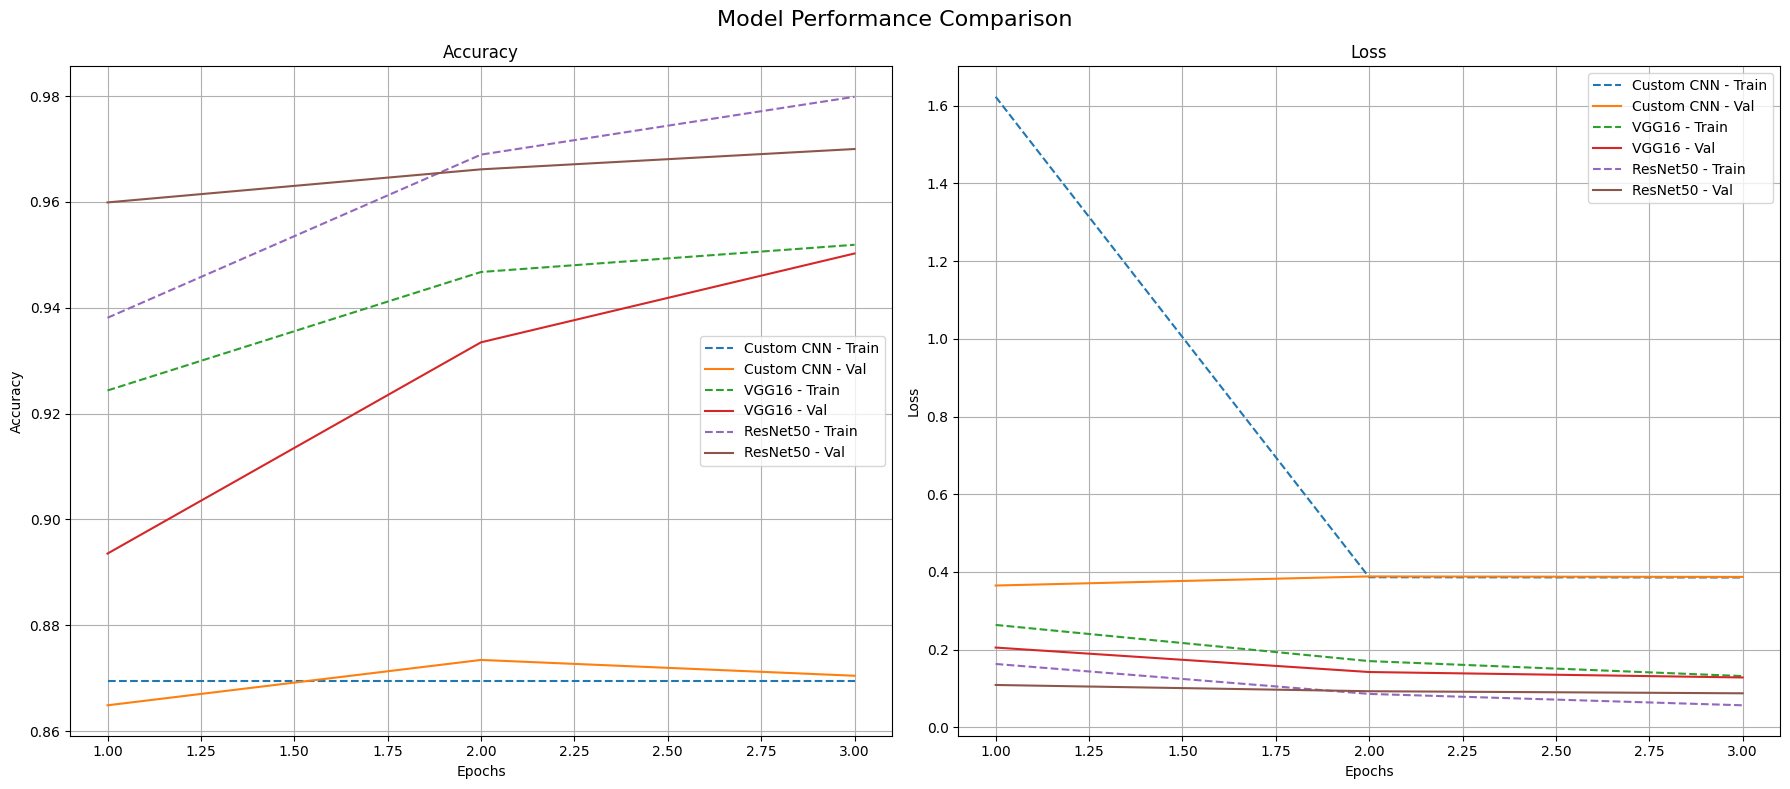

In [149]:
custom_cnn_acc = np.hstack(custom_cnn_accuracy)
custom_cnn_val_acc = np.hstack(custom_cnn_val_acc)
custom_cnn_loss = np.hstack(custom_cnn_loss)
custom_cnn_val_loss = np.hstack(custom_cnn_val_loss)

vgg16_acc = np.hstack(vgg16_accuracy)
vgg16_val_acc = np.hstack(vgg16_val_accuracy)
vgg16_loss = np.hstack(vgg16_loss)
vgg16_val_loss = np.hstack(vgg16_val_loss)

resnet50_acc = np.hstack(resnet50_acc)
resnet50_val_acc = np.hstack(resnet50_accuracy)
resnet50_loss = np.hstack(resnet50_loss)
resnet50_val_loss = np.hstack(resnet50_val_loss)

compare_model_performance_plot(
    vgg16_acc, vgg16_val_acc, vgg16_loss, vgg16_val_loss,
    resnet50_acc, resnet50_val_acc, resnet50_loss, resnet50_val_loss,
    custom_cnn_acc, custom_cnn_val_acc, custom_cnn_loss, custom_cnn_val_loss
)

Predictions are made on the test set are made in order to generate a final classification report, and confusion matrix.

In [91]:
test_generator.reset()
vgg16_predictions = vgg16_model.predict(test_generator, verbose=1)
resnet50_predictions = resnet50_model.predict(test_generator, verbose=1)

1921/1921 ━━━━━━━━━━━━━━━━━━━━ 95s 49ms/step
1921/1921 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step


The previously-made predictions, and actual values are gathered, and fed into ```scikit-learn``` to generate the confusion matrix.

In [92]:
vgg16_predictions=np.hstack(np.round(vgg16_predictions,0))
vgg16_act=y_test.astype('int')
target=["Negative","Positive"]
vgg16_cm = confusion_matrix(vgg16_act, vgg16_predictions)

resnet50_predictions=np.hstack(np.round(resnet50_predictions,0))
resnet50_act=y_test.astype('int')
target=["Negative","Positive"]
resnet50_cm = confusion_matrix(resnet50_act, resnet50_predictions)

The results are then plotted using ```seaborn```.

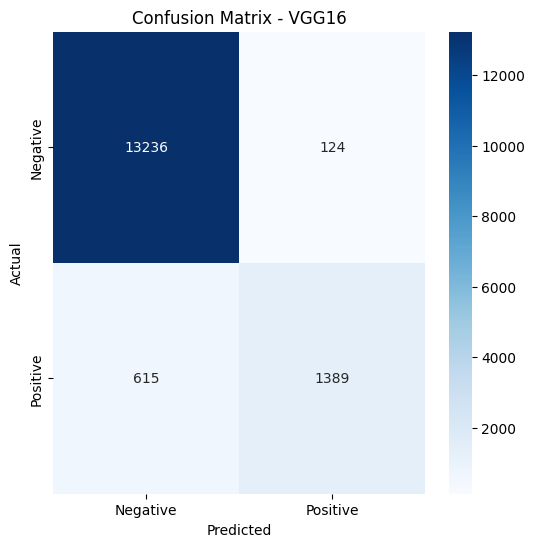

In [93]:
plt.figure(figsize=(6, 6))
sns.heatmap(
    vgg16_cm, annot=True, fmt="d", cmap="Blues", xticklabels=target, yticklabels=target
)
plt.title("Confusion Matrix - VGG16")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

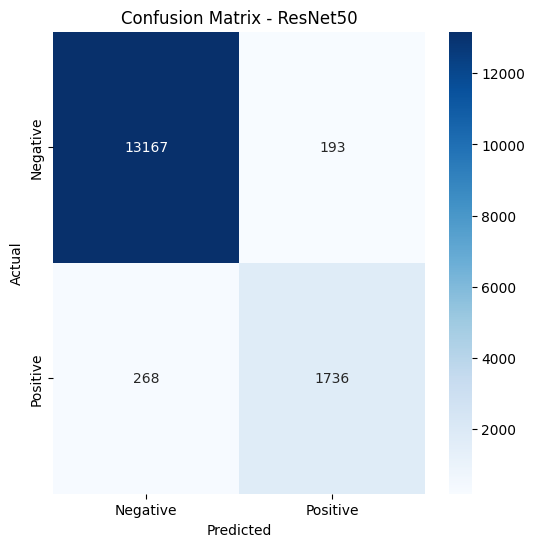

In [94]:
plt.figure(figsize=(6, 6))
sns.heatmap(
    resnet50_cm, annot=True, fmt="d", cmap="Blues", xticklabels=target, yticklabels=target
)
plt.title("Confusion Matrix - ResNet50")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The same values are used to generate the final classification report.

In [95]:
vgg16_report_dict = classification_report(vgg16_act, vgg16_predictions, target_names=target, output_dict=True)
vgg16_df = pd.DataFrame(vgg16_report_dict).transpose()
vgg16_df.style.background_gradient(cmap="Blues").format("{:.2f}")

In [96]:
resnet50_report_dict = classification_report(resnet50_act, resnet50_predictions, target_names=target, output_dict=True)
resnet50_df = pd.DataFrame(resnet50_report_dict).transpose()
resnet50_df.style.background_gradient(cmap="Blues").format("{:.2f}")

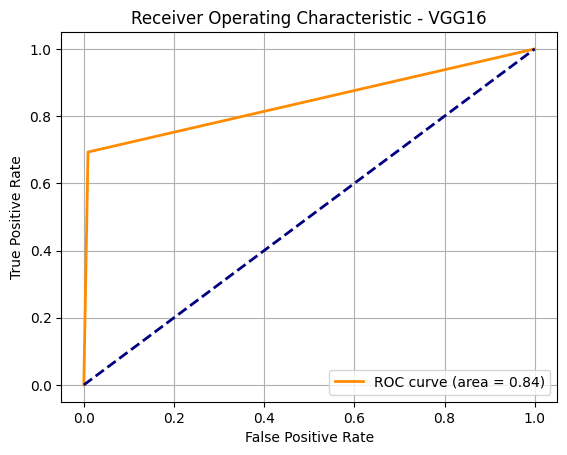

In [97]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(vgg16_act, vgg16_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - VGG16')
plt.legend(loc='lower right')
plt.grid()
plt.show()

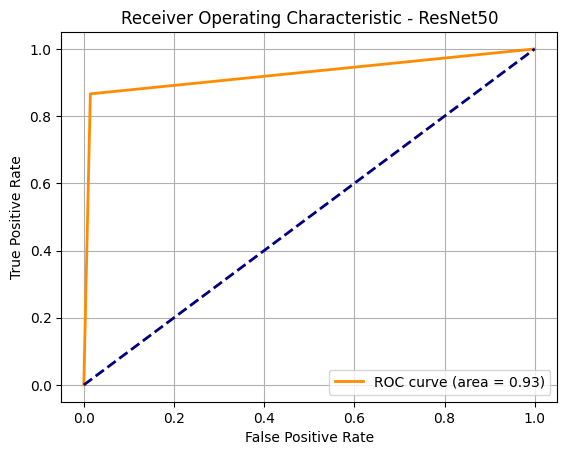

In [98]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(resnet50_act, resnet50_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - ResNet50')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Model Explanation

This final section touches upon XAI or explainable AI, by implementing _Grad-CAM_ through the ```tf-explain``` module. This provides a visual indication of the parts of the image that influenced the classification made of the model, explaining the results achieved. This is done for the first ten images within the testing set, but can easily be done for any other image as well. The following function accepts a path to an image, the model used, and it's final layer, and returns the explained version of the image, and the classification result.

In [99]:
def generate_gradcam(image_path, model, layer_name):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    input_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(input_array)
    predicted_class = np.argmax(preds[0])

    explainer = GradCAM()
    grid = explainer.explain(
        validation_data=(input_array, None),
        model=model,
        class_index=predicted_class,
        layer_name=layer_name,
    )
    return grid, predicted_class

A series of images is then passed through the aforementioned function, and plotted into a singular figure.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/home/isaac/miniconda3/envs/myenv/lib/python3.9/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_61']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


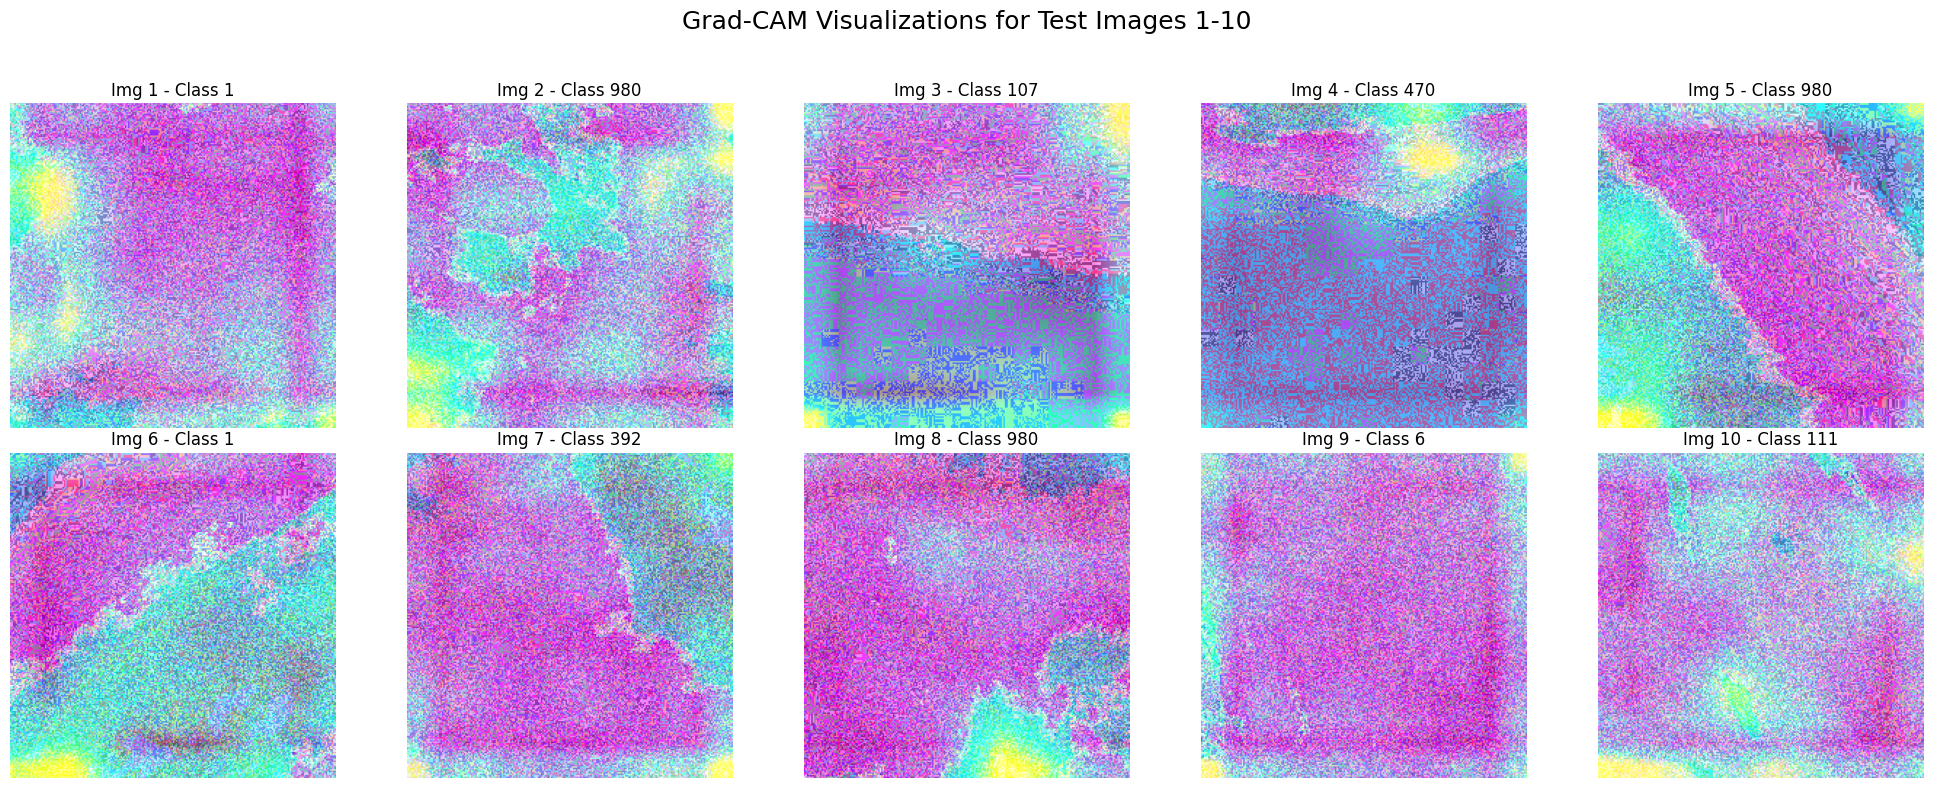

In [101]:
vgg16_base = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Grad-CAM Visualizations for Test Images 1-10", fontsize=18)

for i in range(1, 11):
    grid, predicted_class = generate_gradcam(f"./test/{i}.jpg", model, "block5_conv3")
    
    row = (i - 1) // 5
    col = (i - 1) % 5
    ax = axes[row, col]
    ax.imshow(grid)
    ax.axis("off")
    ax.set_title(f"Img {i} - Class {predicted_class}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In the above plot, warmer colours indicate higher influence on the model's predicted class, and cooler colours the opposite.